In [7]:
from IPython.display import clear_output

In [2]:
!pip install torch torchvision
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html 
clear_output()

In [2]:
import cv2
import numpy as np
import os
from PIL import Image
import json
from sklearn.model_selection import train_test_split
import shutil


def prepare_dataset(base_dir, target_dir):
    categories = ['benign', 'malignant', 'normal']
    images = []
    # Ensure directories exist and clear them
    for sub_dir in ['train', 'val', 'test', 'annotations']:
        full_path = os.path.join(target_dir, sub_dir)
        shutil.rmtree(full_path, ignore_errors=True)
        os.makedirs(full_path, exist_ok=True)

    # Gather images and masks
    for category in categories:
        category_dir = os.path.join(base_dir, category)
        image_files = [f for f in os.listdir(category_dir) if not f.endswith('_mask.png')]
        for image_file in image_files:
            image_path = os.path.join(category_dir, image_file)
            mask_path = image_path.replace('.png', '_mask.png')
            if os.path.exists(mask_path):
                images.append((image_path, mask_path))

    # Split the data
    train_val_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    train_images, val_images = train_test_split(train_val_images, test_size=0.1, random_state=42)

    # Copy files to their respective directories
    def copy_files(file_list, subdir):
        for img_path, mask_path in file_list:
            shutil.copy(img_path, os.path.join(target_dir, subdir, os.path.basename(img_path)))
            shutil.copy(mask_path, os.path.join(target_dir, subdir, os.path.basename(mask_path)))

    copy_files(train_images, 'train')
    copy_files(val_images, 'val')
    copy_files(test_images, 'test')

def mask_to_coco_polygons(mask):
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []
    for contour in contours:
        if len(contour) >= 6:  # Only keep contours with at least 3 points
            contour = contour.flatten().tolist()
            segmentation.append(contour)
    return segmentation

def bounding_box_from_mask(mask):
    y_indices, x_indices = np.where(mask > 0)
    if y_indices.size > 0 and x_indices.size > 0:
        x_min, x_max = x_indices.min(), x_indices.max()
        y_min, y_max = y_indices.min(), y_indices.max()
        return [int(x_min), int(y_min), int(x_max - x_min), int(y_max - y_min)]
    else:
        return [0, 0, 0, 0]  # Empty mask if no mask is found


def gather_images_masks(base_dir):
    image_files = [f for f in os.listdir(base_dir) if not f.endswith('_mask.png')]
    image_mask_pairs = []
    for image_file in image_files:
        image_path = os.path.join(base_dir, image_file)
        mask_path = image_path.replace('.png', '_mask.png')
        if os.path.exists(mask_path):  # Check if the mask exists
            image_mask_pairs.append((image_path, mask_path))
    return image_mask_pairs

def resize_and_save(image_path, size=(128, 128)):
    with Image.open(image_path) as img:
        img = img.resize(size, Image.LANCZOS)
        img.save(image_path)

def create_coco_json(images_dir, annotations_dir, json_filename):
    images_list = []
    annotations = []
    category_id = 1  # Since only one category
    categories = [{'id': category_id, 'name': 'tumor'}]
    annotation_id = 1

    for idx, filename in enumerate(os.listdir(images_dir)):
        if filename.endswith('_mask.png'):
            continue
        image_path = os.path.join(images_dir, filename)
        mask_path = image_path.replace('.png', '_mask.png')

        # Resize and process images and masks
        resize_and_save(image_path)
        resize_and_save(mask_path)

        mask = np.array(Image.open(mask_path).convert('L'))
        bbox = bounding_box_from_mask(mask)
        area = int(np.sum(mask > 0))  # Convert numpy int to Python int
        segmentation = mask_to_coco_polygons(mask)

        images_list.append({
            'id': idx + 1,
            'file_name': filename,
            'width': 128,
            'height': 128
        })

        annotations.append({
            'id': annotation_id,
            'image_id': idx + 1,
            'category_id': category_id,
            'segmentation': segmentation,
            'area': area,
            'bbox': bbox,
            'iscrowd': 0
        })
        annotation_id += 1

    coco_format = {
        'images': images_list,
        'annotations': annotations,
        'categories': categories
    }

    with open(os.path.join(annotations_dir, json_filename), 'w') as f:
        json.dump(coco_format, f, indent=2)

    print(f"Created COCO JSON: {json_filename} with {len(images_list)} images.")

In [3]:
base_dir = './'
target_dir = './data'
prepare_dataset(base_dir, target_dir)
create_coco_json('./data/train', './data/annotations', 'train_annotations.json')
create_coco_json('./data/val', './data/annotations', 'val_annotations.json')
create_coco_json('./data/test', './data/annotations', 'test_annotations.json')

Created COCO JSON: train_annotations.json with 561 images.
Created COCO JSON: val_annotations.json with 63 images.
Created COCO JSON: test_annotations.json with 156 images.


In [4]:
import os
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import numpy as np
import cv2
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# Register your dataset
register_coco_instances("my_dataset_train", {}, "./data/annotations/train_annotations.json", "./data/train")
register_coco_instances("my_dataset_val", {}, "./data/annotations/val_annotations.json", "./data/val")

In [5]:
from detectron2.engine import DefaultPredictor

# Configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Use pre-trained weights
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # Learning rate
cfg.SOLVER.MAX_ITER = 3000  # Approx. 10 epochs, adjust to 5520 for about 20 epochs if needed
cfg.SOLVER.STEPS = [2000, 4500]  # Learning rate decay steps, adjust according to your new MAX_ITER
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class (tumor)
cfg.MODEL.DEVICE = "cpu"

# Training
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[05/02 22:34:19 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[05/02 22:34:19 d2.data.datasets.coco]: Loaded 561 images in COCO format from ./data/annotations/train_annotations.json
[05/02 22:34:19 d2.data.build]: Removed 0 images with no usable annotations. 561 images left.
[05/02 22:34:19 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   tumor    | 561          |
|            |              |
[05/02 22:34:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[05/02 22:34:19 d2.data.build]: Using training sampler TrainingSampler
[05/02 22:34:19 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/02 22:34:19 d2.data.common]: Serializing 561 elements to byte tensors and concatenating them all ...
[05/02 22:34:19 d2.data.common]: Serialized dataset takes 0.24 MiB
[05/02 22:3

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[05/02 22:34:19 d2.engine.train_loop]: Starting training from iteration 0


/Users/kjingruz/anaconda3/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1712608632396/work/aten/src/ATen/native/TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/02 22:35:17 d2.utils.events]:  eta: 2:18:01  iter: 19  total_loss: 1.812  loss_cls: 0.6806  loss_box_reg: 0.4671  loss_mask: 0.6887  loss_rpn_cls: 0.00921  loss_rpn_loc: 0.005016    time: 2.7693  last_time: 2.7952  data_time: 0.1111  last_data_time: 0.0008   lr: 4.9952e-05  
[05/02 22:36:14 d2.utils.events]:  eta: 2:15:07  iter: 39  total_loss: 1.384  loss_cls: 0.2996  loss_box_reg: 0.3744  loss_mask: 0.6592  loss_rpn_cls: 0.0166  loss_rpn_loc: 0.005814    time: 2.6941  last_time: 2.5721  data_time: 0.0009  last_data_time: 0.0007   lr: 9.9902e-05  
[05/02 22:37:10 d2.utils.events]:  eta: 2:15:00  iter: 59  total_loss: 1.187  loss_cls: 0.2379  loss_box_reg: 0.3589  loss_mask: 0.557  loss_rpn_cls: 0.008327  loss_rpn_loc: 0.004379    time: 2.7307  last_time: 2.5438  data_time: 0.0009  last_data_time: 0.0008   lr: 0.00014985  
[05/02 22:38:03 d2.utils.events]:  eta: 2:13:52  iter: 79  total_loss: 1.233  loss_cls: 0.2365  loss_box_reg: 0.4964  loss_mask: 0.4933  loss_rpn_cls: 0.005598  

[05/02 23:01:09 d2.utils.events]:  eta: 1:48:21  iter: 599  total_loss: 0.6527  loss_cls: 0.1255  loss_box_reg: 0.2249  loss_mask: 0.2618  loss_rpn_cls: 0.005594  loss_rpn_loc: 0.002986    time: 2.6715  last_time: 2.9696  data_time: 0.0009  last_data_time: 0.0008   lr: 0.0014985  
[05/02 23:02:03 d2.utils.events]:  eta: 1:47:27  iter: 619  total_loss: 0.5653  loss_cls: 0.106  loss_box_reg: 0.21  loss_mask: 0.2271  loss_rpn_cls: 0.003737  loss_rpn_loc: 0.003524    time: 2.6723  last_time: 3.0634  data_time: 0.0009  last_data_time: 0.0008   lr: 0.0015485  
[05/02 23:02:58 d2.utils.events]:  eta: 1:46:46  iter: 639  total_loss: 0.5855  loss_cls: 0.07028  loss_box_reg: 0.2204  loss_mask: 0.2213  loss_rpn_cls: 0.002632  loss_rpn_loc: 0.003351    time: 2.6744  last_time: 2.5184  data_time: 0.0010  last_data_time: 0.0012   lr: 0.0015984  
[05/02 23:03:53 d2.utils.events]:  eta: 1:46:02  iter: 659  total_loss: 0.6112  loss_cls: 0.1039  loss_box_reg: 0.2791  loss_mask: 0.2117  loss_rpn_cls: 0.0

[05/02 23:27:05 d2.utils.events]:  eta: 1:22:36  iter: 1179  total_loss: 0.4455  loss_cls: 0.04808  loss_box_reg: 0.1615  loss_mask: 0.1874  loss_rpn_cls: 0.001624  loss_rpn_loc: 0.002507    time: 2.6769  last_time: 2.7074  data_time: 0.0010  last_data_time: 0.0009   lr: 0.0025  
[05/02 23:28:01 d2.utils.events]:  eta: 1:21:48  iter: 1199  total_loss: 0.5404  loss_cls: 0.06442  loss_box_reg: 0.2388  loss_mask: 0.2349  loss_rpn_cls: 0.004517  loss_rpn_loc: 0.003322    time: 2.6790  last_time: 2.7916  data_time: 0.0010  last_data_time: 0.0009   lr: 0.0025  
[05/02 23:28:55 d2.utils.events]:  eta: 1:20:58  iter: 1219  total_loss: 0.5866  loss_cls: 0.1035  loss_box_reg: 0.2579  loss_mask: 0.1841  loss_rpn_cls: 0.00385  loss_rpn_loc: 0.002932    time: 2.6796  last_time: 2.8000  data_time: 0.0011  last_data_time: 0.0016   lr: 0.0025  
[05/02 23:29:49 d2.utils.events]:  eta: 1:20:06  iter: 1239  total_loss: 0.5787  loss_cls: 0.09088  loss_box_reg: 0.2711  loss_mask: 0.1983  loss_rpn_cls: 0.00

[05/02 23:54:03 d2.utils.events]:  eta: 0:57:36  iter: 1759  total_loss: 0.5406  loss_cls: 0.07854  loss_box_reg: 0.2004  loss_mask: 0.2128  loss_rpn_cls: 0.002615  loss_rpn_loc: 0.001952    time: 2.7142  last_time: 2.4482  data_time: 0.0008  last_data_time: 0.0007   lr: 0.0025  
[05/02 23:54:57 d2.utils.events]:  eta: 0:56:42  iter: 1779  total_loss: 0.4576  loss_cls: 0.06285  loss_box_reg: 0.2153  loss_mask: 0.2112  loss_rpn_cls: 0.0009771  loss_rpn_loc: 0.001658    time: 2.7138  last_time: 2.7259  data_time: 0.0010  last_data_time: 0.0009   lr: 0.0025  
[05/02 23:55:50 d2.utils.events]:  eta: 0:55:46  iter: 1799  total_loss: 0.4733  loss_cls: 0.06992  loss_box_reg: 0.1965  loss_mask: 0.1822  loss_rpn_cls: 0.001376  loss_rpn_loc: 0.002434    time: 2.7129  last_time: 2.8170  data_time: 0.0010  last_data_time: 0.0008   lr: 0.0025  
[05/02 23:56:41 d2.utils.events]:  eta: 0:54:47  iter: 1819  total_loss: 0.441  loss_cls: 0.0697  loss_box_reg: 0.1707  loss_mask: 0.1539  loss_rpn_cls: 0.0

[05/03 00:19:54 d2.utils.events]:  eta: 0:30:42  iter: 2339  total_loss: 0.386  loss_cls: 0.03925  loss_box_reg: 0.1675  loss_mask: 0.1485  loss_rpn_cls: 0.0006755  loss_rpn_loc: 0.002315    time: 2.7040  last_time: 2.1400  data_time: 0.0010  last_data_time: 0.0008   lr: 0.00025  
[05/03 00:20:47 d2.utils.events]:  eta: 0:29:45  iter: 2359  total_loss: 0.3748  loss_cls: 0.04536  loss_box_reg: 0.1628  loss_mask: 0.1527  loss_rpn_cls: 0.0005625  loss_rpn_loc: 0.002455    time: 2.7035  last_time: 3.0027  data_time: 0.0009  last_data_time: 0.0013   lr: 0.00025  
[05/03 00:21:38 d2.utils.events]:  eta: 0:28:43  iter: 2379  total_loss: 0.4447  loss_cls: 0.04199  loss_box_reg: 0.1865  loss_mask: 0.2069  loss_rpn_cls: 0.000667  loss_rpn_loc: 0.002408    time: 2.7023  last_time: 2.4614  data_time: 0.0009  last_data_time: 0.0009   lr: 0.00025  
[05/03 00:22:35 d2.utils.events]:  eta: 0:27:50  iter: 2399  total_loss: 0.3987  loss_cls: 0.04285  loss_box_reg: 0.1555  loss_mask: 0.1672  loss_rpn_cls

[05/03 00:45:59 d2.utils.events]:  eta: 0:03:39  iter: 2919  total_loss: 0.3998  loss_cls: 0.04324  loss_box_reg: 0.1577  loss_mask: 0.1745  loss_rpn_cls: 0.0008422  loss_rpn_loc: 0.002051    time: 2.7030  last_time: 2.9913  data_time: 0.0010  last_data_time: 0.0015   lr: 0.00025  
[05/03 00:46:58 d2.utils.events]:  eta: 0:02:44  iter: 2939  total_loss: 0.3209  loss_cls: 0.03877  loss_box_reg: 0.1146  loss_mask: 0.1428  loss_rpn_cls: 0.0005711  loss_rpn_loc: 0.001789    time: 2.7045  last_time: 2.3247  data_time: 0.0011  last_data_time: 0.0013   lr: 0.00025  
[05/03 00:47:52 d2.utils.events]:  eta: 0:01:49  iter: 2959  total_loss: 0.341  loss_cls: 0.03067  loss_box_reg: 0.1333  loss_mask: 0.1499  loss_rpn_cls: 0.0005263  loss_rpn_loc: 0.00174    time: 2.7045  last_time: 2.6420  data_time: 0.0009  last_data_time: 0.0007   lr: 0.00025  
[05/03 00:48:44 d2.utils.events]:  eta: 0:00:54  iter: 2979  total_loss: 0.4094  loss_cls: 0.0501  loss_box_reg: 0.169  loss_mask: 0.1639  loss_rpn_cls: 

In [8]:
!pip install ipython pillow
clear_output()

[05/03 01:13:48 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


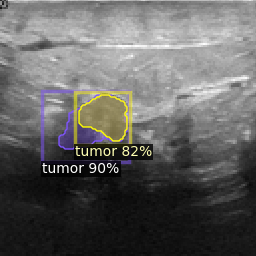

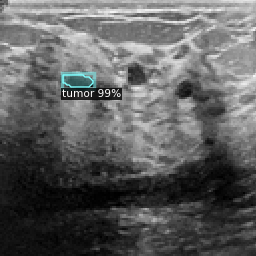

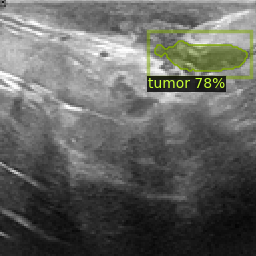

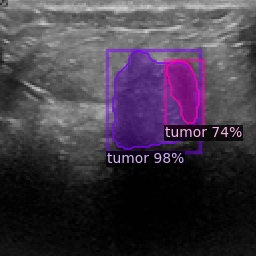

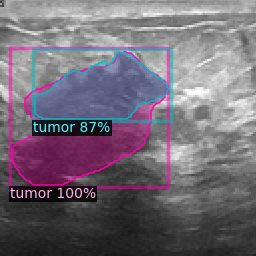

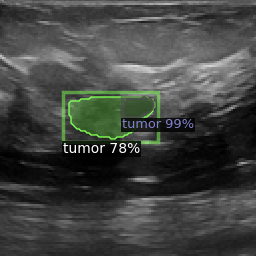

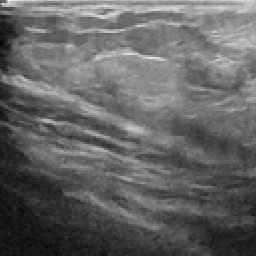

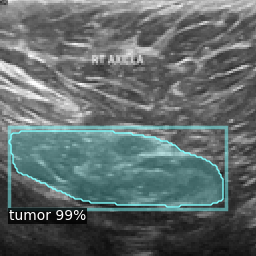

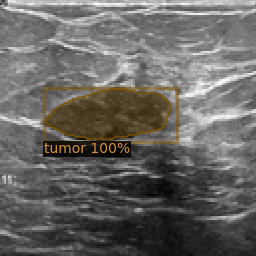

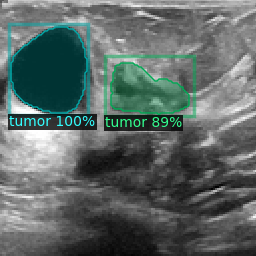

In [22]:
from IPython.display import display
from PIL import Image as PILImage
import cv2
import numpy as np
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor

# Load and configure the model for inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a threshold for this model
predictor = DefaultPredictor(cfg)

# Get a list of image filenames in the test directory
test_dir = "./data/test"
test_images = [f for f in os.listdir(test_dir) if (f.endswith('.jpg') or f.endswith('.png')) and '_mask' not in f]
if not test_images:
    raise Exception("No images found in the test directory.")

# Randomly select 10 images from the test directory
selected_images = random.sample(test_images, min(10, len(test_images)))

for selected_image in selected_images:
    img_path = os.path.join(test_dir, selected_image)

    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Unable to load image at path: {img_path}")

    # Predict using the loaded model
    outputs = predictor(img)

    # Visualize and display the prediction results
    v = Visualizer(img[:, :, ::-1], 
                   metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]), 
                   scale=2.0,  # Adjust scale to make the image larger
                   instance_mode=ColorMode.IMAGE_BW   # Remove the colors of unsegmented pixels
                  )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    output_image = out.get_image()[:, :, ::-1]  # Convert image from BGR to RGB

    # Display in Jupyter Notebook
    display(PILImage.fromarray(output_image))
